# Covid-19 CSCI 334 Project
### Noah Drake, Jacob Roddam and Daniel Hwang

## Overview

This project pulls data from Johns Hopkins to analyze the currently ongoing confirmed, and death cases State-by-State, and predict the growth rate virus in certain time intervals.

**time_series_covid19_confirmed_US.csv**
* UID (int) - unique ID numbers that assignes to the location depends on the region. 
* iso2 (string) - Initial of Province and state in two characters
* iso3 (string) - Initial of Province and state in three characters
* code3 (int) - UNKNOWN
* FIPS (float) - Federal Information Processing Standards code that uniquely identifies counties within the USA
* Admin2 (string) - County name. 
* Province_State (string) - Province, state or dependency name. 
* Country_Region (string) - Name of country, region or sovereignty. 
* Lat (float) - Latitude value
* Long (float) - Longitude value
* Combined_Key (string) - combination of Province_State and Combined_key
* Columns of Dates (int) - Multiple Columns of Dates, number represents the total confirmed cases on the Date. 

**time_series_covid19_death_US.csv**
* UID (int) - 
* iso2 (string) - Initial of Province and state in two characters
* iso3 (string) - Initial of Province and state in three characters
* code3 (int) - UNKNOWN
* FIPS (float) - Federal Information Processing Standards code that uniquely identifies counties within the USA
* Admin2 (string) - County name. 
* Province_State (string) - Province, state or dependency name. 
* Country_Region (string) - Name of country, region or sovereignty. 
* Lat (float) - Latitude value
* Long (float) - Longitude value
* Combined_Key (string) - combination of Province_State and Combined_key
* Columns of Dates (int) - Multiple Columns of Dates, number represents the total death cases on the Date. 

# Goals

1. Analyze the growth rate and death ratio based on the total number of confirmed and death cases. 
    - how many confirmed cases are there now?
    - how fast it grew since the first day?

2. Predict the growth rate of the virus in certain time intervals. 


## Data Cleaning
Handling nulls, missing values, correlations, weird column names, etc. 
Join tables
## Modeling
Feature Selection
-Remove unimportant columns
Train/Test split
## Results/Analysis
Evaluation Metrics
Any relevant visuals
Paragraph summarizing insights/takeaways you gained from the data

## Import Modules, Configure Pandas Settings, and Define Constants

In [1]:
import os
import time
import pandas as pd
import numpy as np
import sklearn.pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# We can play with the constants below to see how far we can accurately forecast the growth rate of counties by state
# ____________________________________________________________


PREDICTOR_INTERVAL = 14  # 2 weeks
FORECASTING_INTERVAL = 7  # 1 week
REGRESSION_INTERVAL = PREDICTOR_INTERVAL + FORECASTING_INTERVAL


# ______________________________________________________________


## Download and Display Raw Data from Johns Hopkins

In [3]:
timeseries_cases_path = os.path.join('Covid-19 Data', 'time_series_covid19_confirmed_US.csv')

if time.time() - os.path.getmtime(timeseries_cases_path) > 86400:
    print('Downloading raw data...')

    # Import Johns Hopkins time series data
    os.system('curl https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
                'csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
                ' > ' + '"' + timeseries_cases_path + '"')

    print('Finished downloading raw data.')

## Cleaning Data for Regression Model

In [4]:
timeseries_dataset = pd.read_csv(timeseries_cases_path)
datasets_bystate_index = []  # Used to index data frames stored in datasets_bystate
datasets_bystate = []
regression_model_bystate = []  # Used to keep track random forest models for each state

# Transforming and cleaning data. Check to see if the prediction and target intervals are available for the
# county being examined by the for-loop. The interval of time needed to make an accurate prediction is
# REGRESSION_INTERVAL = PREDICTOR_INTERVAL + FORECASTING_INTERVAL. If the county examined has not had cases
# for the requisite amount of time specified by REGRESSION_INTERVAL, then it will be dropped from the model.

for state in timeseries_dataset.Province_State.unique():
    print("Building model for state: " + state)

    # Set index and labels
    state_dataset = timeseries_dataset.loc[timeseries_dataset['Province_State'] == state].copy()
    state_dataset.index = pd.RangeIndex(len(state_dataset.index))  # Reset index for proper func. of iloc

    # Drop unneeded attributes
    state_dataset.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS',
                                'Admin2', 'Province_State', 'Country_Region', 'Lat',
                                'Long_', 'Combined_Key'], inplace=True)
    column_names = []  # Store new column names
    for col in range(1, state_dataset.shape[1] + 1):
        column_names.append("Day " + str(col))
    state_dataset.columns = column_names

    if state_dataset.shape[0] < 6:
        print("Unable to build model for state:" + state + " due to an insufficient number counties.")

    else:
        county = 0
        while county < state_dataset.shape[0]:
            has_dropped = False  # Control variable

            # Here, we are counting zeros and adding them to lag_count to shift lag_count columns so that
            # the data is in the format of (day 1, day 2, day 3) where each day is a day that the county
            # is infected with the virus.

            lag_count = 0  # Num. of days the county has NOT been infected.
            for date in range(state_dataset.shape[1]):
                if state_dataset.iloc[county, date] == 0:
                    lag_count += 1
                elif state_dataset.shape[1] - lag_count < REGRESSION_INTERVAL:
                    state_dataset.drop(state_dataset.index[county], inplace=True)
                    state_dataset.index = pd.RangeIndex(len(state_dataset.index))
                    has_dropped = True
                    break
                elif state_dataset.iloc[county, 0] == 0:
                    # Shift the day the cases began in the county to the first column of the data frame
                    for val in range(lag_count, state_dataset.shape[1]):
                        state_dataset.iloc[county, val - lag_count] = state_dataset.iloc[county, val]
                        state_dataset.iloc[county, val] = 0  # To replace shifted values with 0
                    break
                # Check to see if we have a county full of no cases... for some reason these are in here!
                if date == state_dataset.shape[1] - 1 and state_dataset.iloc[county].sum() == 0:
                    state_dataset.drop(state_dataset.index[county], inplace=True)
                    state_dataset.index = pd.RangeIndex(len(state_dataset.index))
                    has_dropped = True

            if not has_dropped:
                county += 1

            if state_dataset.shape[0] < 6:
                break

    if state_dataset.shape[0] >= 6:
        state_dataset.drop(state_dataset.iloc[:, -(state_dataset.shape[1] - REGRESSION_INTERVAL):], axis='columns',
                            inplace=True)
        datasets_bystate.append(state_dataset)
        datasets_bystate_index.append(state)

Building model for state: American Samoa
Unable to build model for state:American Samoa due to an insufficient number counties.
Building model for state: Guam
Unable to build model for state:Guam due to an insufficient number counties.
Building model for state: Northern Mariana Islands
Unable to build model for state:Northern Mariana Islands due to an insufficient number counties.
Building model for state: Puerto Rico
Unable to build model for state:Puerto Rico due to an insufficient number counties.
Building model for state: Virgin Islands
Unable to build model for state:Virgin Islands due to an insufficient number counties.
Building model for state: Alabama
Building model for state: Alaska
Building model for state: Arizona
Building model for state: Arkansas
Building model for state: California
Building model for state: Colorado
Building model for state: Connecticut
Building model for state: Delaware
Unable to build model for state:Delaware due to an insufficient number counties.
Buil

## Example of Cleaning Failure? Examining Alabama's Cases

In [6]:
datasets_bystate[0]

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,Day 11,Day 12,Day 13,Day 14,Day 15,Day 16,Day 17,Day 18,Day 19,Day 20,Day 21
0,1,4,6,6,6,6,6,7,8,10,12,12,12,12,12,12,15,17,19,19,19
1,1,1,1,1,1,2,2,2,3,4,4,5,5,10,15,18,19,20,24,28,29
2,1,2,2,2,3,3,4,9,9,10,10,11,12,14,15,18,20,22,28,29,30
3,2,3,3,4,4,4,5,7,8,9,9,11,13,16,17,17,18,22,24,26,28
4,1,2,4,5,5,5,5,5,6,9,10,10,10,10,10,11,12,12,13,14,16
5,2,2,3,3,3,3,3,2,2,2,2,2,2,3,3,4,4,4,5,8,8
6,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,3,3,6,7,8,8
7,1,1,1,1,1,2,2,2,2,3,3,3,8,9,11,12,18,21,23,34,41
8,1,2,1,2,2,5,10,13,13,17,27,33,36,42,67,80,87,89,94,101,109
9,1,1,1,1,2,2,2,2,4,5,6,6,6,6,7,7,7,7,8,9,9


Issues with DataFrame? The anamolous rows are few in number and should not affect our model significantly...

## Building Random Forest Regression Models Using Recursive Multistep Method

In [15]:
import warnings
warnings.filterwarnings("ignore")

# We analyze the performance of each model with RMSE.
rmse_avg_perstate = [] # A list of rmse for each list of regression models per state
rsq_avg_perstate = [] # A list of avg R^2 for the models for each state
models_bystate = [] # A list of lists of Regression Models...each state has its own list which as been recursively constructed
for state_dataset in datasets_bystate:
    rmse_permodel = []  # rmse per recursive step of the algorithm
    rsq_permodel = [] # R^2 per model
    rfr_list_perstate = [] # Random forests for the state described by state_dataset
        
    # Begin with base case: Use just the raw data.
    train, test = train_test_split(state_dataset, test_size=.2)
        
    train_X = train.iloc[:,:PREDICTOR_INTERVAL]
    train_y = train.iloc[:,-(FORECASTING_INTERVAL)]
    test_X = test.iloc[:,:PREDICTOR_INTERVAL]
    test_y = test.iloc[:,-(FORECASTING_INTERVAL)]
    for response_variable_index in range(FORECASTING_INTERVAL):
        rfr = RandomForestRegressor(random_state=0)   
            
        rfr_list_perstate.append(rfr.fit(train_X, train_y)) # Add model to state model collection
        forecasted_cases_train = rfr.predict(train_X)
        forecasted_cases_test = rfr.predict(test_X)
            
        rsq_permodel.append(rfr.score(test_X, test_y))
        rmse_permodel = mean_squared_error(test_y, forecasted_cases_test)**.5
            
        # Check: Are we at our base case?
        if (response_variable_index != 0):
            # Nope!
            day_added = "Day " + str(FORECASTING_INTERVAL + response_variable_index + 1)
            # Recursive addition of forecasted variables to model
            se = pd.Series(forecasted_cases_train)
            train_X[day_added] = se.values
            train_y = train.iloc[:,-(FORECASTING_INTERVAL - response_variable_index)].copy()
                
            # Recursive addition of forecasted variables to model
            se = pd.Series(forecasted_cases_test)
            test_X[day_added] = se.values
            test_y = test.iloc[:, -(FORECASTING_INTERVAL - response_variable_index)].copy()
                
    rmse_avg_perstate.append(np.sum(rmse_permodel)/FORECASTING_INTERVAL)
    rsq_avg_perstate.append(np.sum(rsq_permodel)/FORECASTING_INTERVAL)
    models_bystate.append(rfr_list_perstate)
            

The above code gave us warnings based on the possibility of chained indexing (http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy), but checking over our code it appears that everything checks out. Perhaps there was a way to avoid these warnings?

## Performance Analysis

In [16]:
for i in range(len(models_bystate)):
    print("rmse for " + datasets_bystate_index[i] + ": " + str(rmse_avg_perstate[i]))

rmse for Alabama: 1.19225904595145
rmse for Alaska: 0.32722706339850344
rmse for Arizona: 1.318453536493098
rmse for Arkansas: 1.9327189013228536
rmse for California: 4.001772026192726
rmse for Colorado: 2.8175565570187175
rmse for Connecticut: 12.2998364432464
rmse for Florida: 3.4455027616320066
rmse for Georgia: 3.3296638625774717
rmse for Hawaii: 0.9591796026835023
rmse for Idaho: 15.600696469591664
rmse for Illinois: 11.257635244393088
rmse for Indiana: 8.573464961750608
rmse for Iowa: 1.245594955404539
rmse for Kansas: 2.842773908918315
rmse for Kentucky: 3.160209369529038
rmse for Louisiana: 48.437885969293234
rmse for Maine: 9.730293428467695
rmse for Maryland: 9.277599201236033
rmse for Massachusetts: 40.61843398743773
rmse for Michigan: 115.28986664381348
rmse for Minnesota: 7.027185447179035
rmse for Mississippi: 2.460851825930134
rmse for Missouri: 9.004246316032068
rmse for Montana: 1.125549325823968
rmse for Nebraska: 0.9270221507748405
rmse for Nevada: 0.7157385225437158

RMSE looks to be pretty low for almost all states! A good sign...but what about the variation in the response which can be explained by our models?

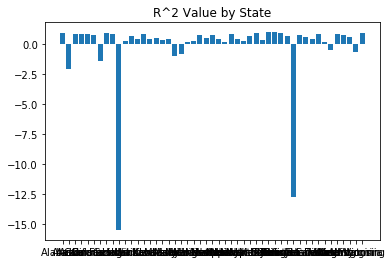

In [17]:
plt.bar(datasets_bystate_index, rsq_avg_perstate)
plt.title("R^2 Value by State")
plt.show()

In [18]:
for i in range(len(models_bystate)):
    print("rsq for " + datasets_bystate_index[i] + ": " + str(rsq_avg_perstate[i]))

rsq for Alabama: 0.9358839473988197
rsq for Alaska: -2.0849492063492066
rsq for Arizona: 0.8394221440574073
rsq for Arkansas: 0.8160239561440576
rsq for California: 0.8121923040008073
rsq for Colorado: 0.7313613219819324
rsq for Connecticut: -1.4370055113048146
rsq for Florida: 0.9017074017366625
rsq for Georgia: 0.8251965776861461
rsq for Hawaii: -15.49281360870406
rsq for Idaho: 0.23779085666569402
rsq for Illinois: 0.6389053587159716
rsq for Indiana: 0.3821897727108431
rsq for Iowa: 0.8330153847737135
rsq for Kansas: 0.41947668042781394
rsq for Kentucky: 0.48474038792296276
rsq for Louisiana: 0.34737523973997736
rsq for Maine: 0.43406855843999026
rsq for Maryland: -0.9894570507300754
rsq for Massachusetts: -0.8080804779482936
rsq for Michigan: 0.18034523485040793
rsq for Minnesota: 0.238671957522624
rsq for Mississippi: 0.7538551549124921
rsq for Missouri: 0.5000606671143697
rsq for Montana: 0.7322783624627087
rsq for Nebraska: 0.43753560703244426
rsq for Nevada: 0.15930867346938765

## Conclusion: Overall, the ability for RandomForestRegressor to forecast the spread of Covid-19 shows promise, but will require some better cleaning, better feature extraction, and even a new method of time series forecasting to make more accurate models. It appears that states with lesser amounts of counties tended to perform worse in our models. This is almost certainly because our models were built off of the values for every in every state, not the cases collectively summed in each county per state. 